## 0. Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../utils')
from load_data import ames_housing
from preprocess_data import cat2int

import functools
import tensorflow as tf
from tensorflow.python.feature_column.feature_column import _LazyBuilder
tf.__version__

'1.9.0'

## 1. Load data

In [2]:
dirfolder = '../data/Ames-Housing'
numvalid = 100
train, valid, testdf, listnumeric, dictcategorical = ames_housing(dirfolder, numvalid)
traindf, trainy = train
validdf, validy = valid

Number of train samples is 1360.
Number of valid samples is 100.
Number of test samples is 1459.
Number of feature columns is 79.
Checking listnumeric ...
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
Checking dictcategorical ...
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


/home/ymtoo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ymtoo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## 2. Preprocess input data

In [35]:
traindata = cat2int(traindf, dictcategorical)
validdata = cat2int(validdf, dictcategorical)
testdata = cat2int(testdf, dictcategorical)

## 3. Create dataflow graphs

In [103]:
# hyperparameters
k = 0.9
learning_rate_0 = 1e-1
batch_size = 50
iterations = 500000
monitor = 10000
threshold = 0.001
keep_prob_input_0 = 1.0
keep_prob_a_0 = 0.9

# network size
num_train, num_in = traindata.shape
num_hidden_1 = 100
num_hidden_2 = 50
num_hidden_3 = 25
num_out = 1

# create network graph
## input and hidden layer 1
x = tf.placeholder(tf.float32, [None, num_in])
keep_prob_input = tf.placeholder(tf.float32)
keep_prob_a = tf.placeholder(tf.float32)
x_drop = tf.nn.dropout(x, keep_prob_input)
W_1 = tf.Variable(tf.random_normal([num_in, num_hidden_1], stddev=0.1))
b_1 = tf.Variable(tf.random_normal([num_hidden_1], stddev=0.1))
y_1 = tf.matmul(x_drop, W_1) + b_1
a_1 = tf.nn.relu(y_1)
a_1_drop = tf.nn.dropout(a_1, keep_prob_a)

## hidden layer 1 and 2
W_2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2], stddev=0.1))
b_2 = tf.Variable(tf.random_normal([num_hidden_2], stddev=0.1))
y_2 = tf.matmul(a_1_drop, W_2) + b_2
a_2 = tf.nn.relu(y_2)
a_2_drop = tf.nn.dropout(a_2, keep_prob_a)

## hidden layer 2 and 3
W_3 = tf.Variable(tf.random_normal([num_hidden_2, num_hidden_3], stddev=0.1))
b_3 = tf.Variable(tf.random_normal([num_hidden_3], stddev=0.1))
y_3 = tf.matmul(a_2_drop, W_3) + b_3
a_3 = tf.nn.relu(y_3)
a_3_drop = tf.nn.dropout(a_3, keep_prob_a)

## hidden layer 3 and output 
W_4 = tf.Variable(tf.random_normal([num_hidden_3, num_out], stddev=0.1))
b_4 = tf.Variable(tf.random_normal([num_out], stddev=0.1))
y_out = tf.matmul(a_3_drop, W_4) + b_4

# create training graph
learning_rate = tf.placeholder(tf.float32)
y_ = tf.placeholder(tf.float32, [None, num_out])
cost = tf.losses.mean_squared_error(y_, y_out)
train = tf.train.AdadeltaOptimizer(learning_rate).minimize(cost)

## 4. Training

In [104]:
# initialize
session = tf.Session()
session.run(tf.global_variables_initializer())

# train
start = 0
last_perf = 0
for i in range(iterations):
    session.run(train, feed_dict={x: traindata[start:start+batch_size, :], 
                                  y_: trainy[start:start+batch_size],
                                  keep_prob_input: keep_prob_input_0,
                                  keep_prob_a: keep_prob_a_0, 
                                  learning_rate: learning_rate_0})
    start += batch_size
    if start > num_train-batch_size: 
        start = 0
    if i % monitor == 0:
        perf = session.run(cost, feed_dict={x: validdata, 
                                            y_: validy,
                                            keep_prob_input: 1.0,
                                            keep_prob_a: 1.0})
        print("{}: {}".format(i, perf))
        if np.abs(perf-last_perf) < threshold:
            print("Difference between two consercutive costs is too small.")
            break
        last_perf = perf
        learning_rate_0 = learning_rate_0*k

predtrainy = session.run(y_out, feed_dict={x: traindata, 
                                           keep_prob_input: 1.0,
                                           keep_prob_a: 1.0})
predvalidy = session.run(y_out, feed_dict={x: validdata, 
                                           keep_prob_input: 1.0,
                                           keep_prob_a: 1.0})
predtesty = session.run(y_out, feed_dict={x: testdata, 
                                           keep_prob_input: 1.0,
                                           keep_prob_a: 1.0})
session.close()

0: 36878880768.0
1000: 1766092800.0
2000: 1604308992.0
3000: 1521937664.0
4000: 1473076224.0
5000: 1423453696.0
6000: 1383252352.0
7000: 1350903040.0
8000: 1317608704.0
9000: 1285363968.0
10000: 1264019072.0
11000: 1249762048.0
12000: 1228443520.0
13000: 1215303168.0
14000: 1201249792.0
15000: 1193441792.0
16000: 1181106688.0
17000: 1171015808.0
18000: 1167762944.0
19000: 1161225216.0
20000: 1152509440.0
21000: 1144216576.0
22000: 1139388544.0
23000: 1133813248.0
24000: 1130416256.0
25000: 1126763264.0
26000: 1122692352.0
27000: 1116928512.0
28000: 1114087296.0
29000: 1111414912.0
30000: 1104122752.0
31000: 1099971328.0
32000: 1092838528.0
33000: 1090739456.0
34000: 1084796800.0
35000: 1077203072.0
36000: 1074065280.0
37000: 1070958208.0
38000: 1066654656.0
39000: 1064164160.0
40000: 1060864960.0
41000: 1059030656.0
42000: 1060027648.0
43000: 1046300096.0
44000: 1044676224.0
45000: 1040795648.0
46000: 1044262336.0
47000: 1034746176.0
48000: 1031353472.0
49000: 1028563584.0
50000: 10275

## 5. Plot results

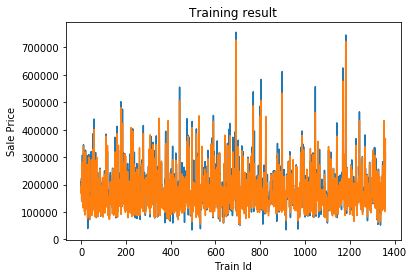

In [105]:
fig, ax = plt.subplots()
ax.plot(trainy, label='True')
ax.plot(predtrainy, label='Predict')
ax.set_xlabel('Train Id')
ax.set_ylabel('Sale Price')
ax.set_title('Training result');

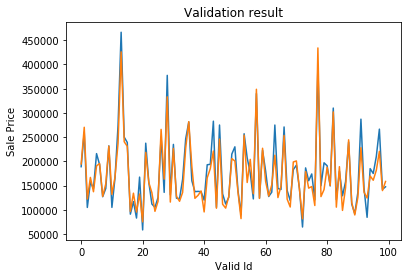

In [106]:
fig, ax = plt.subplots()
ax.plot(validy, label='True')
ax.plot(predvalidy, label='Predict')
ax.set_xlabel('Valid Id')
ax.set_ylabel('Sale Price')
ax.set_title('Validation result');

## 6. Save testing result for submission

In [107]:
sub_dict = {'Id': testdf.index.tolist(), 'SalePrice': predtesty.flatten()}
dnnreg_submission = pd.DataFrame(sub_dict)
dnnreg_submission.set_index('Id', inplace=True)
dnnreg_submission.to_csv('dnnreg_submission')

## 2. Setting TensorFlow input data

In [5]:
def feature_column(listnumeric, dictcategorical):
    listcategorical = list(dictcategorical.keys())
    numeric_cols = []
    for num in listnumeric:
        numeric_cols.append(tf.feature_column.numeric_column(num))
    categorical_cols = []
    for cat in listcategorical:
        cattemp = tf.feature_column.categorical_column_with_vocabulary_list(
                cat, dictcategorical[cat])
        categorical_cols.append(cattemp)
    return numeric_cols, categorical_cols

numeric_cols , categorical_cols = feature_column(listnumeric, dictcategorical)
#indicator_cols = list(map(tf.feature_column.indicator_column, categorical_cols))
embedding_cols = [tf.feature_column.embedding_column(cat, int(len(cat.vocabulary_list)**0.25)) 
                  for cat in categorical_cols]

In [46]:
global_step = tf.Variable(0, trainable=False)
tf.train.exponential_decay(
            learning_rate=0.1,
            global_step=2,
            decay_steps=10000,
            decay_rate=0.96)

<tf.Tensor 'ExponentialDecay_6:0' shape=() dtype=float32>

## 3. Regression using deep neural network

In [55]:
def easy_input_fn(df, label, num_epochs=1, shuffle=False, batch_size=None):
    if label is None:
        inputs = dict(df)
    else:
        inputs = (dict(df), label)
    ds = tf.data.Dataset.from_tensor_slices(inputs)
    
    if shuffle:
        ds = ds.shuffle(10000)
    if batch_size is not None:
        ds = ds.batch(batch_size).repeat(num_epochs)
    else:
        ds = ds.batch(df.shape[0]).repeat(num_epochs)
    return ds

train_inpf =  functools.partial(easy_input_fn, 
                                traindf,
                                label=trainy,  
                                num_epochs=200, 
                                shuffle=True, 
                                batch_size=64)

valid_inpf =  functools.partial(easy_input_fn, 
                                validdf, 
                                label=validy,
                                num_epochs=1, 
                                shuffle=False, 
                                batch_size=100)

test_inpf =  functools.partial(easy_input_fn, 
                               testdf, 
                               label=None,
                               num_epochs=1, 
                               shuffle=False, 
                               batch_size=64)

reg = tf.estimator.DNNRegressor(
    feature_columns=numeric_cols+embedding_cols,
    hidden_units=[512, 256, 128],
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.1))
reg.train(train_inpf)
result = reg.evaluate(valid_inpf)

for key,value in sorted(result.items()):
    print('%s: %0.2f' % (key, value))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpx8tnq31h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fde101d1048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpx8tnq31h/model.ckpt.
INFO:ten

In [56]:
train_predf = functools.partial(easy_input_fn, 
                                traindf,
                                label=trainy)

regtrainpred = reg.predict(train_predf)
regvalidpred = reg.predict(valid_inpf)

trainypred = np.zeros((trainy.size))    
for i, p in enumerate(regtrainpred):
    trainypred[i] = p['predictions'][0]

validypred = np.zeros((validy.size))
for i, p in enumerate(regvalidpred):
    validypred[i] = p['predictions'][0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpx8tnq31h/model.ckpt-4400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpx8tnq31h/model.ckpt-4400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


## 4. Plot result

432181886.803
487548978.238


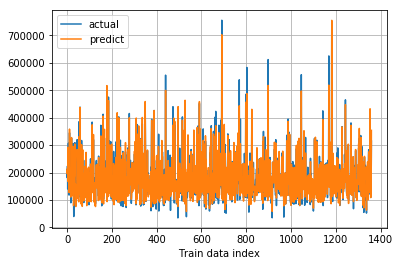

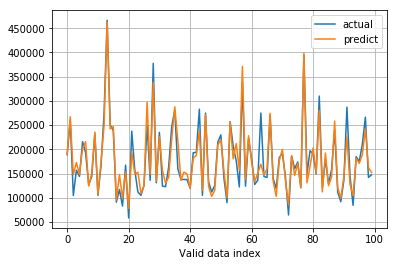

In [57]:
print(np.mean(np.abs(trainy-trainypred)**2))
fig, ax = plt.subplots()
ax.plot(trainy, label='actual')
ax.plot(trainypred, label='predict')
ax.set_xlabel('Train data index')
ax.grid()
ax.legend()

print(np.mean(np.abs(validy-validypred)**2))
fig, ax = plt.subplots()
ax.plot(validy, label='actual')
ax.plot(validypred, label='predict')
ax.set_xlabel('Valid data index')
ax.grid()
ax.legend()